In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

concentration_col = 'Concentration (uM)'
concentration_val = 33
ic50_col = 'PriA-SSB Dose response: IC50 (uM)'
median_inhib_col = 'Median % negative control (%)'
inhib_col = '% negative control (%)'

res_full_df = pd.read_csv('../datasets/Zenodo/v1/enamine_PriA-SSB_dose_response_2021-06-16_run.tsv', delimiter='\t', keep_default_na=False)
res_full_df = res_full_df[res_full_df['Control State'] == '']
res_full_df[concentration_col] = res_full_df[concentration_col].astype(float)
res_df = res_full_df[res_full_df[concentration_col] == concentration_val]
res_df = res_df[['Molecule Name', 'Structure (CXSMILES)', concentration_col, inhib_col]]
res_df.index = res_df['Molecule Name'].tolist()
res_df[median_inhib_col] = 0
for smssf_id, row in res_df.groupby('Molecule Name').median().iterrows():
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
    res_df.loc[smssf_id, median_inhib_col] = row[inhib_col]
res_df = res_df.reset_index(drop=True)

inhib_col = '% Inhibition'
hit_thresh = 50.0
res_df[inhib_col] = 100.0 - res_df[median_inhib_col]
res_df['Hit_median_50_thresh'] = (res_df[inhib_col] >= hit_thresh).astype(int)

all_runs_df = pd.read_csv('../datasets/Zenodo/v1/enamine_dose_reponse_curves.tsv', delimiter='\t').drop_duplicates('Synonyms')
res_df = res_df.merge(all_runs_df[['Molecule Name', 'Synonyms']], on='Molecule Name')

assert res_df['Molecule Name'].unique().shape[0] == 68
assert res_df['Synonyms'].unique().shape[0] == 68

res_df = res_df.rename({'Molecule Name' : 'SMSSF Molecule ID', 'Synonyms': 'ID Enamine', 'Structure (CXSMILES)': 'SMSSF SMILES'}, axis=1)

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

cluster_df = pd.read_csv('../datasets/Zenodo/v1/train_ams_real_cluster.csv.gz')

ams_df = pd.read_csv('../datasets/Zenodo/v1/ams_order_results.csv.gz')
train_df = pd.read_csv('../datasets/Zenodo/v1/training_df_single_fold.csv.gz')

real_df = res_df.copy().drop_duplicates('SMSSF Molecule ID')
real_cpd_info_df = pd.read_csv('../datasets/Zenodo/v1/enamine_final_list.csv.gz').drop('Hit', axis=1)
real_df = real_df.merge(real_cpd_info_df, on='ID Enamine')

In [3]:
train_hits = train_df[train_df['PriA-SSB AS Activity'] == 1]
ams_hits = ams_df[ams_df['Hit'] == 1]
real_hits = real_df[real_df['Hit_median_50_thresh'] == 1]

train_hits_inhib = train_hits['PriA-SSB AS % inhibition (Primary Median)'].values # median of primary at 33 uM since not all cpds have retest 
ams_hits_inhib = ams_hits[['Replicate1', 'Replicate2']].mean(axis=1).values # mean/median of replicate 1 and 2 at 33 uM
real_hits_inhib = real_hits['% Inhibition'].values # mean/median of quadruplicates at 33 uM

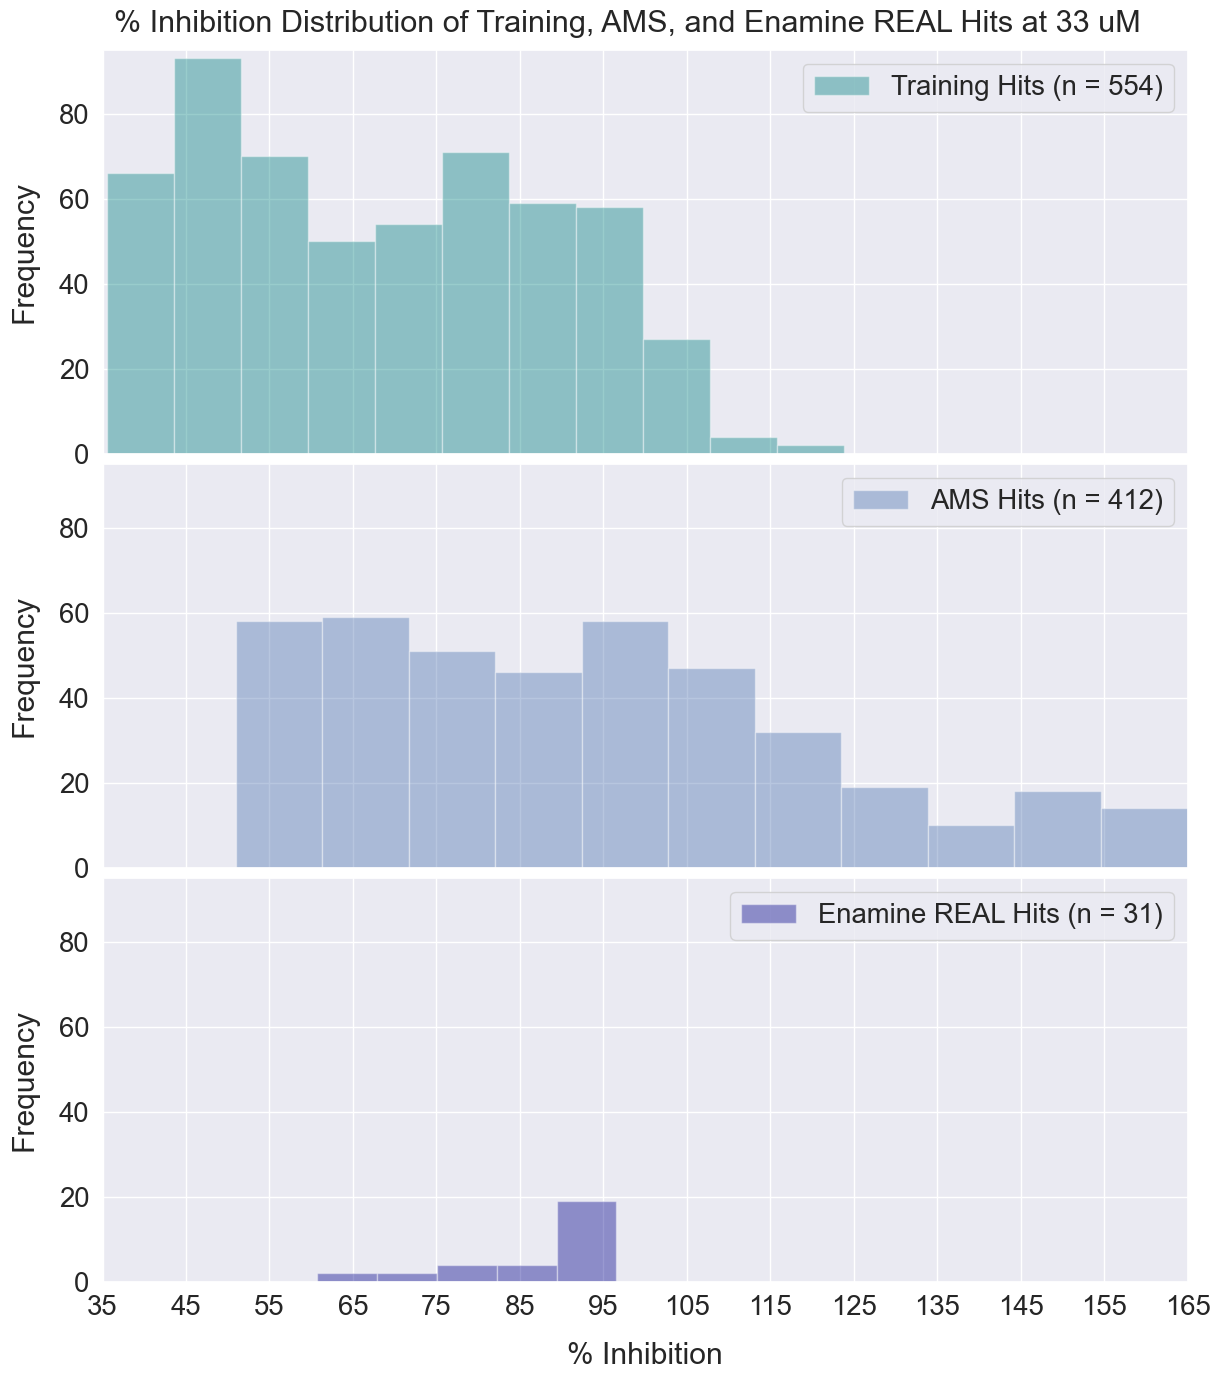

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(14, 16)

bin_range= np.linspace(35, 170, 30)
legends = ['Training Hits (n = {})'.format(train_hits_inhib.shape[0]), 
            'AMS Hits (n = {})'.format(ams_hits_inhib.shape[0]), 
            'Enamine REAL Hits (n = {})'.format(real_hits_inhib.shape[0])]

fig, axes = plt.subplots(3,1, figsize=figsize, sharex=True)

sns.distplot(train_hits_inhib, norm_hist=False, kde=False, ax=axes[0], color='teal')#, color='maroon', bins=bin_range)
sns.distplot(ams_hits_inhib, norm_hist=False, kde=False, ax=axes[1], color='b')
sns.distplot(real_hits_inhib, norm_hist=False, kde=False, ax=axes[2], color='darkblue')

for i, ax in enumerate(axes):
    ax.set_xlim([35,165])
    ax.set_ylim([0,95])
    ax.set_xticks([int(i) for i in np.linspace(35, 165, 14)])
    ax.set_ylabel('Frequency', labelpad=15);
    ax.legend([legends[i]])
    
plt.subplots_adjust(wspace=0, hspace=0.025)
plt.xlabel('% Inhibition', labelpad=15)

plt.suptitle('% Inhibition Distribution of Training, AMS, and Enamine REAL Hits at 33 uM', 
             y=.905, fontsize=22)

plt.show()

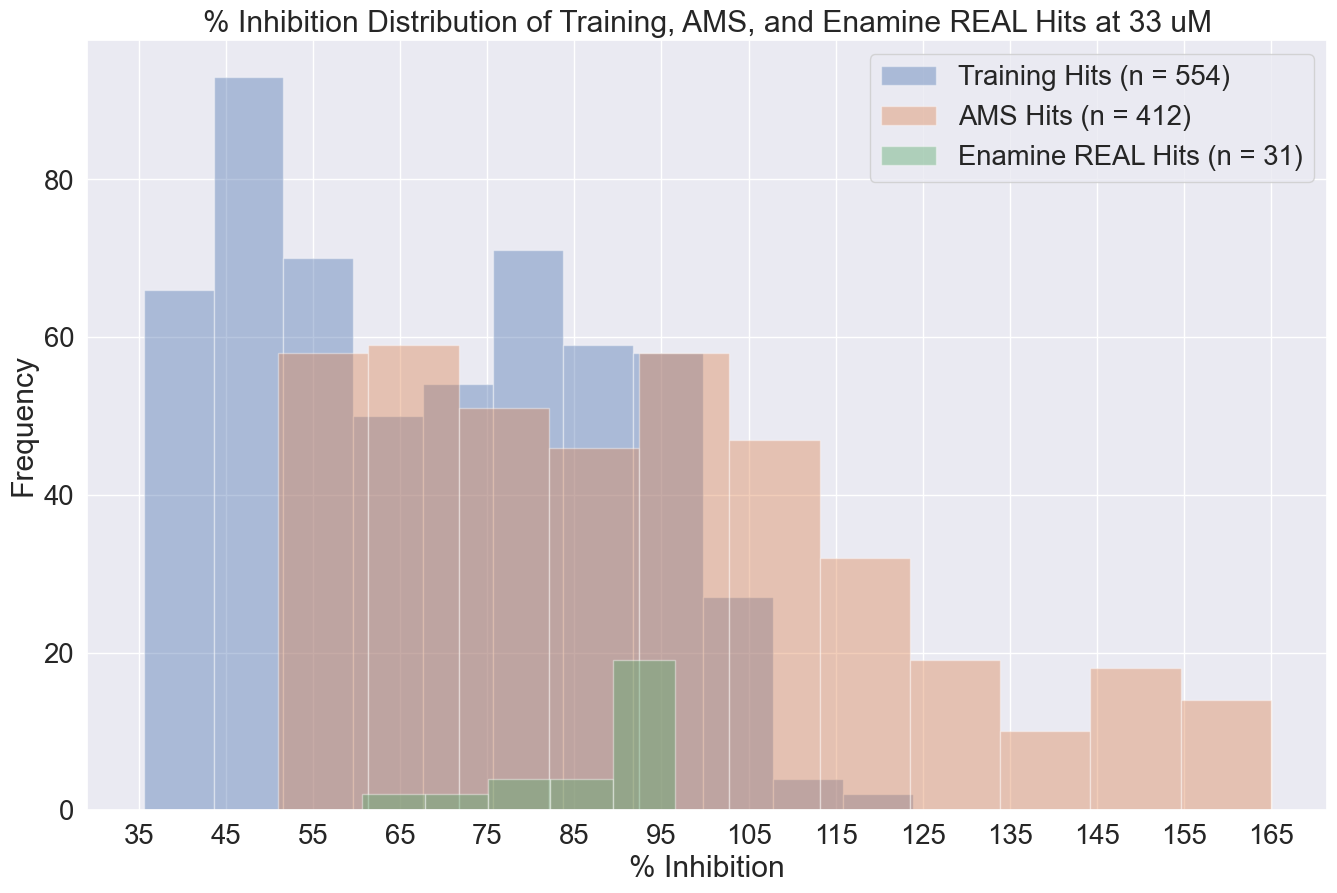

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)
sns.set_context("paper");sns.set(font_scale=1.8);figsize=(16, 10)

bin_range= np.linspace(35, 170, 30)
plt.figure(figsize=figsize)

sns.distplot(train_hits_inhib, norm_hist=False, kde=False)#, color='maroon', bins=bin_range)
sns.distplot(ams_hits_inhib, norm_hist=False, kde=False)
sns.distplot(real_hits_inhib, norm_hist=False, kde=False)
plt.title('% Inhibition Distribution of Training, AMS, and Enamine REAL Hits at 33 uM')
plt.xlabel('% Inhibition'); plt.ylabel('Frequency');
plt.xticks([int(i) for i in np.linspace(35, 165, 14)])
plt.legend(['Training Hits (n = {})'.format(train_hits_inhib.shape[0]), 
            'AMS Hits (n = {})'.format(ams_hits_inhib.shape[0]), 
            'Enamine REAL Hits (n = {})'.format(real_hits_inhib.shape[0])])
plt.show()